In [1]:
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
import medmnist
from medmnist import INFO

In [2]:
data_flag = "retinamnist"
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [3]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor()
])

# load the data
_train_dataset = DataClass(split='train', transform=data_transform, download=download, root="../data/")
_valid_dataset = DataClass(split='val', transform=data_transform, download=download, root="../data/")
_test_dataset = DataClass(split='test', transform=data_transform, download=download, root="../data/")

dataset = ConcatDataset([_train_dataset, _valid_dataset, _test_dataset])

BATCH_SIZE = 128

train_loader = DataLoader(_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(_valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# train, test = torch.utils.data.random_split(dataset, [len(_train_dataset) + len(_valid_dataset), len(_test_dataset)])
# train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
# test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)

Using downloaded and verified file: ../data/retinamnist.npz
Using downloaded and verified file: ../data/retinamnist.npz
Using downloaded and verified file: ../data/retinamnist.npz


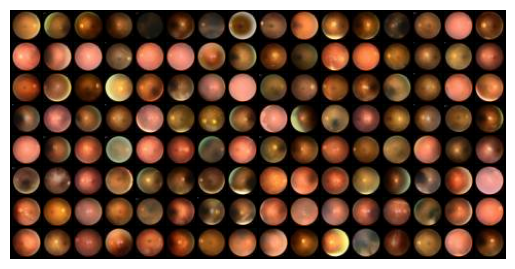

In [4]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

img_batch, _ = next(iter(train_loader))
plt.imshow(make_grid(img_batch, nrow=16).permute(1, 2, 0))
plt.axis('off')
plt.show()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
from src.model import VAE, SimpleCNNClassifier
from src.trainer import CDVAETrainer, SimpleCNNTrainer
from src.model import interpolate_latent

%load_ext autoreload
%autoreload 2

In [7]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

In [24]:
cnn = SimpleCNNClassifier(n_class=5, in_channel=3).to(device)
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
trainer = SimpleCNNTrainer(cnn, optimizer, criterion, 10, device, transform)

In [25]:
trainer.fit(41, train_loader, valid_loader)

val-epoch 0: 100%|██████████| 1/1 [00:00<00:00, 142.76it/s]


val_aupr: {0: 0.78, 1: 0.183, 2: 0.343, 3: 0.185, 4: 0.055}
0.309
val_auroc: {0: 0.762, 1: 0.572, 2: 0.616, 3: 0.582, 4: 0.465}
0.599
val_acc: 0.417


val-epoch 10: 100%|██████████| 1/1 [00:00<00:00, 149.52it/s]


val_aupr: {0: 0.875, 1: 0.386, 2: 0.474, 3: 0.445, 4: 0.119}
0.46
val_auroc: {0: 0.829, 1: 0.803, 2: 0.794, 3: 0.818, 4: 0.77}
0.803
val_acc: 0.583


val-epoch 20: 100%|██████████| 1/1 [00:00<00:00, 142.54it/s]


val_aupr: {0: 0.873, 1: 0.438, 2: 0.528, 3: 0.451, 4: 0.19}
0.496
val_auroc: {0: 0.831, 1: 0.833, 2: 0.825, 3: 0.81, 4: 0.765}
0.813
val_acc: 0.608


val-epoch 30: 100%|██████████| 1/1 [00:00<00:00, 120.26it/s]


val_aupr: {0: 0.88, 1: 0.423, 2: 0.52, 3: 0.445, 4: 0.214}
0.496
val_auroc: {0: 0.848, 1: 0.809, 2: 0.833, 3: 0.8, 4: 0.789}
0.816
val_acc: 0.575


val-epoch 40: 100%|██████████| 1/1 [00:00<00:00, 121.44it/s]

val_aupr: {0: 0.871, 1: 0.415, 2: 0.515, 3: 0.364, 4: 0.275}
0.488
val_auroc: {0: 0.831, 1: 0.803, 2: 0.825, 3: 0.784, 4: 0.8}
0.809
val_acc: 0.542


In [26]:
trainer._valid(test_loader, True, 0)

val-epoch 0: 100%|██████████| 4/4 [00:00<00:00, 159.30it/s]

val_aupr: {0: 0.819, 1: 0.193, 2: 0.376, 3: 0.453, 4: 0.112}
0.391
val_auroc: {0: 0.849, 1: 0.646, 2: 0.709, 3: 0.807, 4: 0.68}
0.738
val_acc: 0.535


In [28]:
from sklearn.manifold import TSNE

In [29]:
hs = []
labels = []
with torch.no_grad():
    for X, label in tqdm(train_loader):
        X = X.to(device)
        label = label.to(device)

        h = cnn.net(X)
        hs.append(h)
        labels.append(label)

hs = torch.cat(hs, dim=0)
labels = torch.cat(labels, dim=0)


tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
hs_tsne = tsne.fit_transform(hs.cpu().numpy())

100%|██████████| 9/9 [00:00<00:00, 118.42it/s]


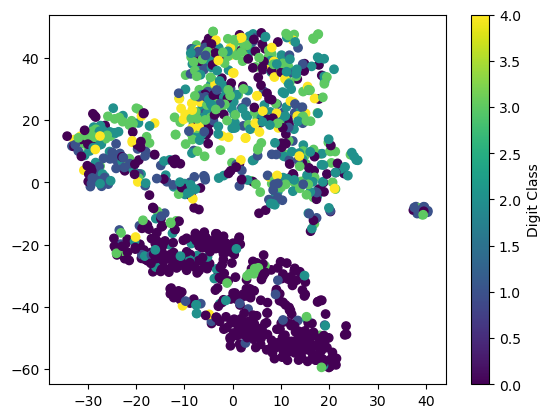

In [30]:
plt.scatter(hs_tsne[:, 0], hs_tsne[:, 1], alpha=1, 
            c=labels.cpu().numpy(), cmap='viridis')
plt.colorbar(label='Digit Class')

In [52]:
Z_DIM = 32
TEMP = 0.1
ALPHA = [10, 10]
LABEL_FLIPPING = True
vae = VAE(total_z_dim=Z_DIM, in_channel=3).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=2e-4, weight_decay=1e-2)
trainer = CDVAETrainer(
    vae,
    optimizer,
    sim_fn="cosine",
    hyperparameter={"temperature": TEMP, "beta": 1, "loc": 0, "scale": 1,
                    "alpha": ALPHA, "label_flipping": LABEL_FLIPPING},
    verbose_period=30,
    device=device,
    transform=transform
)

In [53]:
trainer.fit(391, train_loader, valid_loader)

val-epoch 0: 100%|██████████| 1/1 [00:00<00:00, 66.67it/s]


val_recontr_loss=257.404, val_kl_c=0.003, val_kl_s=0.007, val_c_loss=1.296, val_s_loss=0.371
gMIG: 0.031


val-epoch 30: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s]


val_recontr_loss=143.562, val_kl_c=1.940, val_kl_s=1.716, val_c_loss=0.960, val_s_loss=0.400
gMIG: 0.104


val-epoch 60: 100%|██████████| 1/1 [00:00<00:00, 76.94it/s]


val_recontr_loss=122.151, val_kl_c=1.800, val_kl_s=1.741, val_c_loss=0.972, val_s_loss=0.394
gMIG: 0.096


val-epoch 90: 100%|██████████| 1/1 [00:00<00:00, 95.03it/s]


val_recontr_loss=109.600, val_kl_c=1.618, val_kl_s=1.768, val_c_loss=0.929, val_s_loss=0.417
gMIG: 0.065


val-epoch 120: 100%|██████████| 1/1 [00:00<00:00, 83.31it/s]


val_recontr_loss=96.011, val_kl_c=1.516, val_kl_s=1.778, val_c_loss=0.943, val_s_loss=0.406
gMIG: 0.068


val-epoch 150: 100%|██████████| 1/1 [00:00<00:00, 90.90it/s]


val_recontr_loss=88.889, val_kl_c=1.390, val_kl_s=1.810, val_c_loss=0.936, val_s_loss=0.396
gMIG: 0.075


val-epoch 180: 100%|██████████| 1/1 [00:00<00:00, 82.60it/s]


val_recontr_loss=81.116, val_kl_c=1.331, val_kl_s=1.914, val_c_loss=1.033, val_s_loss=0.387
gMIG: 0.057


val-epoch 210: 100%|██████████| 1/1 [00:00<00:00, 100.01it/s]


val_recontr_loss=74.159, val_kl_c=1.232, val_kl_s=1.819, val_c_loss=0.988, val_s_loss=0.426
gMIG: 0.065


val-epoch 240: 100%|██████████| 1/1 [00:00<00:00, 83.28it/s]


val_recontr_loss=63.252, val_kl_c=1.093, val_kl_s=1.915, val_c_loss=1.120, val_s_loss=0.395
gMIG: 0.056


val-epoch 270: 100%|██████████| 1/1 [00:00<00:00, 90.97it/s]


val_recontr_loss=57.022, val_kl_c=1.056, val_kl_s=1.887, val_c_loss=1.090, val_s_loss=0.418
gMIG: 0.045


val-epoch 300: 100%|██████████| 1/1 [00:00<00:00, 80.98it/s]


val_recontr_loss=50.611, val_kl_c=1.011, val_kl_s=1.959, val_c_loss=1.144, val_s_loss=0.411
gMIG: 0.042


val-epoch 330: 100%|██████████| 1/1 [00:00<00:00, 90.98it/s]


val_recontr_loss=49.030, val_kl_c=0.932, val_kl_s=1.915, val_c_loss=1.194, val_s_loss=0.405
gMIG: 0.035


val-epoch 360: 100%|██████████| 1/1 [00:00<00:00, 90.77it/s]


val_recontr_loss=41.211, val_kl_c=0.843, val_kl_s=2.004, val_c_loss=1.243, val_s_loss=0.402
gMIG: 0.021


val-epoch 390: 100%|██████████| 1/1 [00:00<00:00, 90.81it/s]


val_recontr_loss=38.493, val_kl_c=0.770, val_kl_s=1.928, val_c_loss=1.223, val_s_loss=0.415
gMIG: 0.027


In [54]:
mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for _ in tqdm(range(1)):
        for X, label in train_loader:
            # X = transform(X)
            X, label = X.to(device), label.to(device)

            _, latent_params = vae(X)
            mu_cs.append(latent_params['mu_c'])
            mu_ss.append(latent_params['mu_s'])
            labels.append(label)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


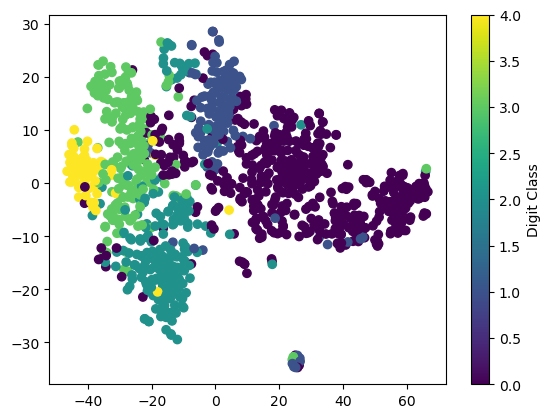

In [55]:
plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=1, 
            c=labels.cpu().numpy(), cmap='viridis')
plt.colorbar(label='Digit Class')

In [56]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

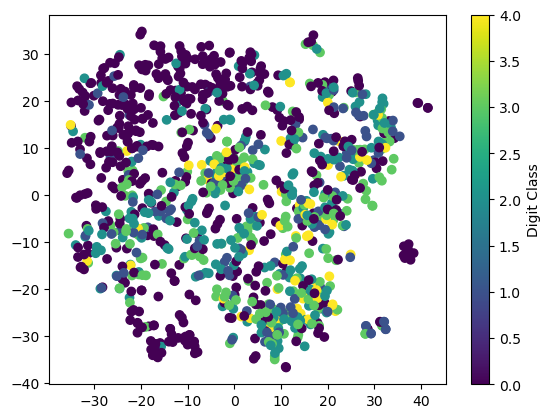

In [57]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=1, 
            c=labels.cpu().numpy(), cmap='viridis')
plt.colorbar(label='Digit Class')

In [58]:
vae.eval()
for p in vae.parameters():
    p.requires_grad = False

In [59]:
from src.trainer import DownstreamMLPTrainer
mlp = torch.nn.Sequential(
    torch.nn.Linear(int(Z_DIM / 2), 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 5),
).to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
trainer = DownstreamMLPTrainer(vae, mlp, optimizer, criterion, 20, device, transform)
trainer.fit(101, train_loader, valid_loader)

val-epoch 0: 100%|██████████| 1/1 [00:00<00:00, 125.01it/s]


val_aupr: {0: 0.476, 1: 0.066, 2: 0.205, 3: 0.219, 4: 0.045}
0.202
val_auroc: {0: 0.404, 1: 0.226, 2: 0.46, 3: 0.584, 4: 0.358}
0.406
val_acc: 0.058


val-epoch 20: 100%|██████████| 1/1 [00:00<00:00, 125.00it/s]


val_aupr: {0: 0.842, 1: 0.334, 2: 0.289, 3: 0.253, 4: 0.219}
0.387
val_auroc: {0: 0.816, 1: 0.699, 2: 0.611, 3: 0.66, 4: 0.575}
0.672
val_acc: 0.467


val-epoch 40: 100%|██████████| 1/1 [00:00<00:00, 124.85it/s]


val_aupr: {0: 0.849, 1: 0.349, 2: 0.315, 3: 0.266, 4: 0.228}
0.401
val_auroc: {0: 0.799, 1: 0.731, 2: 0.657, 3: 0.664, 4: 0.643}
0.699
val_acc: 0.492


val-epoch 60: 100%|██████████| 1/1 [00:00<00:00, 125.01it/s]


val_aupr: {0: 0.849, 1: 0.352, 2: 0.33, 3: 0.262, 4: 0.23}
0.405
val_auroc: {0: 0.8, 1: 0.733, 2: 0.678, 3: 0.661, 4: 0.652}
0.705
val_acc: 0.492


val-epoch 80: 100%|██████████| 1/1 [00:00<00:00, 118.56it/s]


val_aupr: {0: 0.847, 1: 0.344, 2: 0.337, 3: 0.256, 4: 0.233}
0.403
val_auroc: {0: 0.799, 1: 0.728, 2: 0.688, 3: 0.655, 4: 0.67}
0.708
val_acc: 0.483


val-epoch 100: 100%|██████████| 1/1 [00:00<00:00, 125.01it/s]

val_aupr: {0: 0.844, 1: 0.346, 2: 0.346, 3: 0.254, 4: 0.235}
0.405
val_auroc: {0: 0.797, 1: 0.731, 2: 0.694, 3: 0.655, 4: 0.677}
0.711
val_acc: 0.483


In [60]:
trainer._valid(test_loader, True, 0)

val-epoch 0: 100%|██████████| 4/4 [00:00<00:00, 139.04it/s]

val_aupr: {0: 0.718, 1: 0.145, 2: 0.314, 3: 0.294, 4: 0.094}
0.313
val_auroc: {0: 0.76, 1: 0.582, 2: 0.643, 3: 0.727, 4: 0.636}
0.67
val_acc: 0.465


In [65]:
def display_util(idx1, idx2, z: torch.Tensor, model: VAE, z_dim):
    with torch.no_grad():
        z1, z2 = z[idx1], z[idx2]
        display(transforms.ToPILImage()(model.decode(z1.view(1, -1))[0]))
        display(transforms.ToPILImage()(model.decode(z2.view(1, -1))[0]))
        z_inter = interpolate_latent(latent1=z1[z_dim:], latent2=z2[z_dim:], num_steps=11, device=device)
        z_combined = torch.cat([z1[:z_dim][None, :].repeat(11, 1), z_inter], dim=1)
        x_inter = model.decode(z_combined)
        print("interpolate style:")
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()

        z_inter = interpolate_latent(latent1=z1[:z_dim], latent2=z2[:z_dim], num_steps=11, device=device)
        z_combined = torch.cat([z_inter, z1[z_dim:][None, :].repeat(11, 1)], dim=1)
        x_inter = model.decode(z_combined)
        print("interpolate content:")
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()

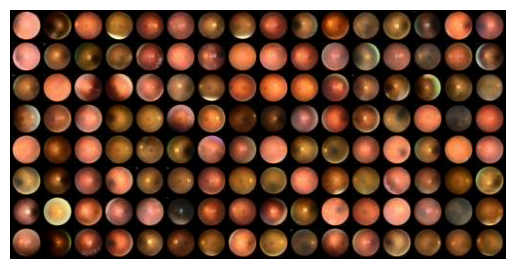

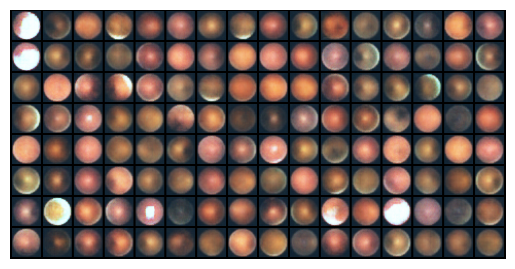

tensor([[2, 1, 0, 0, 0, 0, 2, 2, 0, 3, 2, 2, 0, 3, 0, 0],
        [0, 2, 4, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 3, 0, 0],
        [3, 1, 0, 0, 0, 3, 1, 0, 1, 0, 0, 0, 3, 3, 1, 1],
        [1, 0, 0, 3, 3, 0, 1, 1, 2, 0, 0, 1, 0, 0, 4, 0],
        [2, 2, 0, 1, 0, 3, 0, 1, 0, 2, 3, 1, 4, 3, 0, 0],
        [2, 0, 0, 4, 3, 0, 0, 1, 3, 0, 2, 1, 0, 2, 3, 4],
        [2, 1, 0, 0, 0, 3, 0, 0, 0, 4, 0, 0, 3, 0, 2, 2],
        [0, 2, 0, 0, 2, 1, 3, 2, 3, 2, 0, 0, 2, 2, 2, 2]], dtype=torch.int32)


In [61]:
X, y = next(iter(test_loader))
X = X.to(device)
vae.eval()
X_hat, _, z = vae(X.clone(), explicit=True)


plt.imshow(make_grid(X, nrow=16).permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()

plt.imshow(make_grid(X_hat, nrow=16).permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()
print(y.reshape(-1, 16))

In [62]:
torch.where(y == 0)[0]

tensor([  2,   3,   4,   5,   8,  12,  14,  15,  16,  19,  20,  21,  22,  23,
         25,  26,  28,  30,  31,  34,  35,  36,  39,  41,  42,  43,  49,  50,
         53,  57,  58,  60,  61,  63,  66,  68,  70,  72,  78,  79,  81,  82,
         85,  86,  89,  92,  98,  99, 100, 102, 103, 104, 106, 107, 109, 112,
        114, 115, 122, 123])

In [63]:
torch.where(y == 4)[0]

tensor([ 18,  62,  76,  83,  95, 105])

interpolate style:


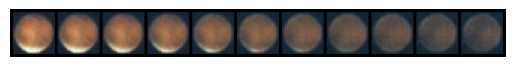

interpolate content:


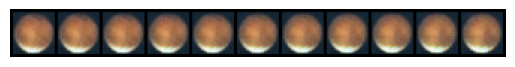

In [71]:
display_util(idx1=3, idx2=62, z=z, model=vae, z_dim=16)